# 実験1: 各情報量の性質 → パラメータを変えて実験
結果: 差がある、ない、1つの図で比較して見られる


In [ ]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 2
    for d in np.arange(0, 1.0, 0.2):
        A = np.array([[0.03, d], [d, 0.03]])
        SigmaE = np.array([[0.2, 0.03], [0.03, 0.2]])

        initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
        state_list = var.generate(initiali_state, A, SigmaE, N=10000)
        SigmaX = np.cov(state_list.T)
        yield {
            "d": d,
            "A": A,
            "SigmaE": SigmaE,
            "SigmaX": SigmaX,
            "state_list": state_list,
            "N": N,
            "mask": np.eye(N, N),
            "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
        }

In [ ]:
import gaii_cond_linear
import geoii
import pandas as pd
from IPython.display import display
result = []
for data in create_data():
    N = data["N"]
    model_gaii = gaii_cond_linear.fit_q(data["state_list"], data["mask"])
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], data["mask"])
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))
result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"])
display(result)
result.plot()

# 実験2: 属性をクラスタリングできる

In [ ]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

In [ ]:
import gaii_cond_linear
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask in candidate_masks:
    N = data["N"]
    model_gaii = gaii_cond_linear.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

# 実験3: 実データで試してみた

In [ ]:
from statsmodels.tsa.api import VAR
def create_data():
    table = pd.read_table("stats.tsv", index_col="Date")
    display(table)
    table[["jp", "fr", "ge"]].plot()
    
    table_pct = table.pct_change()[["jp", "fr", "ge"]]
    table_pct.plot()
    table_pct = table_pct[1:-1].to_numpy()
    
    N = 3
    ar = VAR(table_pct).fit(trend="n", maxlags=1)
    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.01, size=1)[0]
    state_list = var.generate(initiali_state, ar.params, ar.sigma_u, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "N": N,
        "A": ar.params,
        "SigmaE": ar.sigma_u,
        "SigmaX": SigmaX,
        "state_list": table_pct,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(ar.sigma_u))
    }

data = create_data()
import mip
import gaii_cond_linear
import geoii
import pandas as pd
from IPython.display import display

N = data["N"]
candidate_masks, candidate_list = mip.generate_masks(set(range(N)))
result = []
for mask in candidate_masks:
    model_gaii = gaii_cond_linear.fit_q(data["state_list"], mask)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)

# 実験４: 長期記憶のあるネットワークの利用

In [84]:
import numpy as np
from numpy.linalg import det
import var

def create_data():
    N = 4
    A = np.array([
        [0.4, 0.4, 0, 0],
        [0.4, 0.4, 0, 0],
        [0, 0, 0.4, 0.4],
        [0, 0, 0.4, 0.4],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE = L @ L.T

    initiali_state = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.1, size=1)[0]
    state_list = var.generate(initiali_state, A, SigmaE, N=10000)
    SigmaX = np.cov(state_list.T)
    return {
        "A": A,
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "mask": np.eye(N, N),
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

In [85]:
import gaii_joint_dense
import importlib
importlib.reload(gaii_joint_dense)
import geoii
import pandas as pd
from IPython.display import display
import mip
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))

result = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    model_gaii = gaii_joint_dense.fit_q(data["state_list"], ls, length=4, debug=True)
    gaii_result = model_gaii["js"]

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

([0], [1, 2, 3])


KeyboardInterrupt: 

([0], [1, 2, 3])
Generator(
  (activation): ReLU()
  (linear1_1): Linear(in_features=4, out_features=4, bias=True)
  (linear2_1): Linear(in_features=12, out_features=12, bias=True)
  (linear1_2): Linear(in_features=4, out_features=4, bias=True)
  (linear2_2): Linear(in_features=12, out_features=12, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[Count 0/20000]    [JS: -0.012647] [G loss: 1.393563] [D loss: 1.411589]
[Count 100/20000]    [JS: 0.016868] [G loss: 1.460268] [D loss: 1.352559]
[Count 200/20000]    [JS: 0.037186] [G loss: 1.526132] [D loss: 1.311923]
[Count 300/20000]    [JS: 0.056097] [G loss: 1.600433] [D loss: 1.274100]
[Count 400/20000]    [JS: 0.070940] [G loss: 1.658445] [D loss: 1.244414]
[Count 500/20000]    [JS: 0.087042] [G loss: 1.716574] [D loss: 1.212210]
[Count 600/

/Users/sasano/gaii/src/visualize.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


(1.1010453533153168, 0.32518201875956076, 0.5687627477242548)
([0, 3], [1, 2])
Generator(
  (activation): ReLU()
  (linear1_1): Linear(in_features=8, out_features=8, bias=True)
  (linear2_1): Linear(in_features=8, out_features=8, bias=True)
  (linear1_2): Linear(in_features=8, out_features=8, bias=True)
  (linear2_2): Linear(in_features=8, out_features=8, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[Count 0/20000]    [JS: -0.076812] [G loss: 1.303210] [D loss: 1.539919]
[Count 100/20000]    [JS: -0.052588] [G loss: 1.342659] [D loss: 1.491471]
[Count 200/20000]    [JS: -0.012852] [G loss: 1.399231] [D loss: 1.411999]
[Count 300/20000]    [JS: 0.016190] [G loss: 1.459790] [D loss: 1.353914]
[Count 400/20000]    [JS: 0.037832] [G loss: 1.535065] [D loss: 1.310631]
[Count 500/20000]    [JS:

,MI,gaii,geoii
"({0}, {1, 2, 3})",1.101045,0.424658,7.001577e-01
"({1}, {0, 2, 3})",1.101045,0.368526,8.358560e-01
"({2}, {0, 1, 3})",1.101045,0.265904,5.742716e-01
"({3}, {0, 1, 2})",1.101045,0.168683,5.019882e-01
"({0, 1}, {2, 3})",1.101045,0.164332,5.960464e-08
"({0, 2}, {1, 3})",1.101045,0.325182,5.687627e-01
"({0, 3}, {1, 2})",1.101045,0.442543,4.524293e-01


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

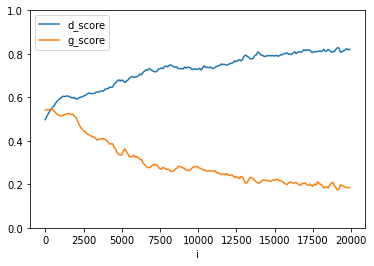

<Figure size 432x288 with 0 Axes>

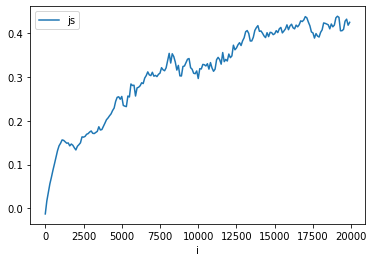

<Figure size 432x288 with 0 Axes>

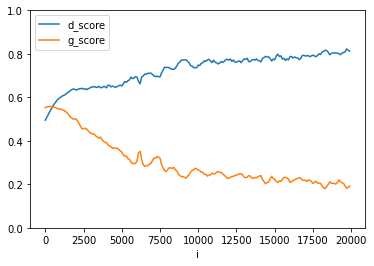

<Figure size 432x288 with 0 Axes>

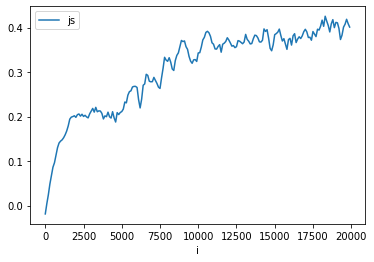

<Figure size 432x288 with 0 Axes>

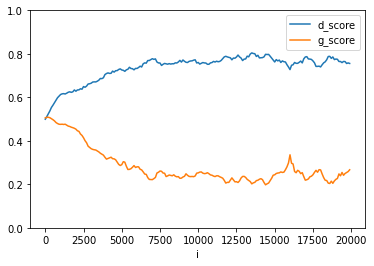

<Figure size 432x288 with 0 Axes>

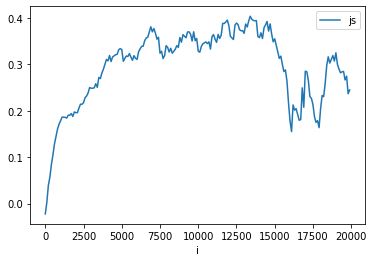

<Figure size 432x288 with 0 Axes>

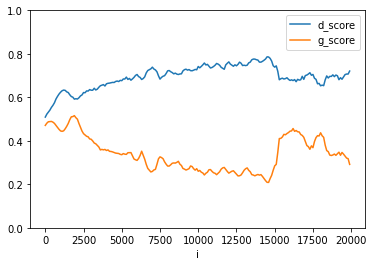

<Figure size 432x288 with 0 Axes>

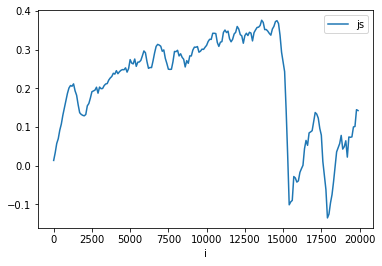

<Figure size 432x288 with 0 Axes>

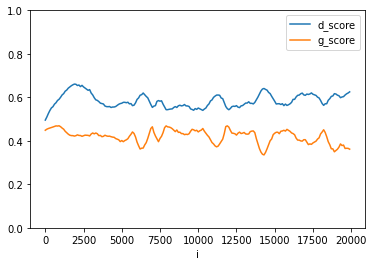

<Figure size 432x288 with 0 Axes>

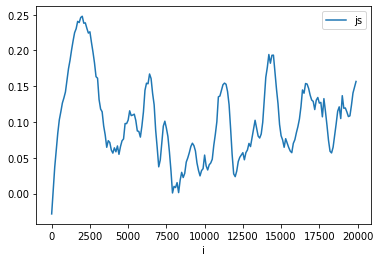

<Figure size 432x288 with 0 Axes>

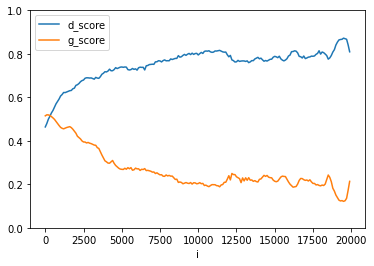

<Figure size 432x288 with 0 Axes>

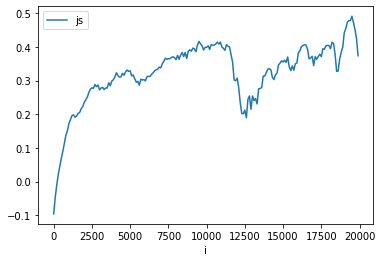

<Figure size 432x288 with 0 Axes>

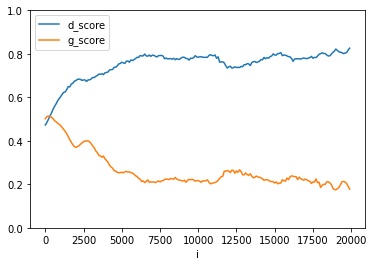

<Figure size 432x288 with 0 Axes>

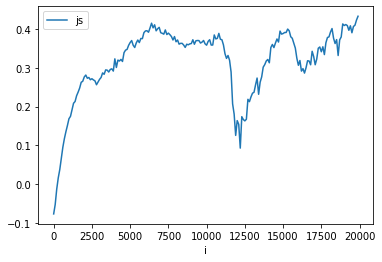

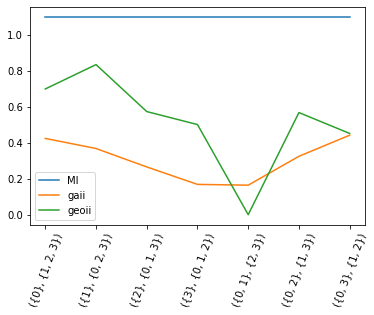

In [56]:
import gaii_joint_dense
import importlib
importlib.reload(gaii_joint_dense)
import geoii
import pandas as pd
from IPython.display import display
import mip
import visualize
import matplotlib.pyplot as plt

importlib.reload(visualize)
data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))
plt.ion()

result = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    model_gaii = gaii_joint_dense.fit_q(data["state_list"], ls, length=4, debug=True, n_step=20000)
    gaii_result = model_gaii["js"]
    visualize.failure_check(model_gaii)
    visualize.js_all(model_gaii)

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    print((MI, gaii_result, geoii_result))
    result.append((MI, gaii_result, geoii_result))

result = pd.DataFrame(result, columns=["MI", "gaii", "geoii"], index=candidate_list)
display(result)
ax = result.plot()
ax.tick_params(axis='x', rotation=70)
ax

In [86]:
import gaii_joint_dense
import gaii_joint_linear
import gaii_joint_lstm
import gaii_cond_dense
import gaii_cond_linear
import gaii_cond_lstm

modules = [
    gaii_joint_dense,
    gaii_joint_linear,
    gaii_joint_lstm,
    gaii_cond_dense,
    gaii_cond_linear,
    gaii_cond_lstm
]

import importlib
for m in modules:
    importlib.reload(m)
import geoii
import pandas as pd
from IPython.display import display
import mip
import visualize
import matplotlib.pyplot as plt

data = create_data()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))
plt.ion()

result_all = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    result = {}
    for m in modules:
        print(m.__name__)
        model_gaii = m.fit_q(data["state_list"], ls, length=4, debug=True, n_step=20000)
        gaii_result = model_gaii["js"]
        #visualize.failure_check(model_gaii)
        #visualize.js_all(model_gaii)
        result[m.__name__] = gaii_result

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    result["MI"] = MI
    result["geoii"] = geoii_result
    print(result)
    result_all.append(result)

result_plot = pd.DataFrame.from_records(result_all, index=candidate_list)
display(result_plot)
ax = result_plot.plot()
ax.tick_params(axis='x', rotation=70)
ax

([0], [1, 2, 3])
gaii_joint_dense
Generator(
  (seq1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4, out_features=4, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 1))
  )
  (seq2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 3))
  )
  (linear_corr): Linear(in_features=4, out_features=4, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[Count 0/20000]    [JS: -0.155582] [G loss: 1.223384] [D loss: 1.697459]
[Count 100/20000]    [JS: -0.116708] [G loss: 1.237278] [D loss: 1.619710

KeyboardInterrupt: 

,gaii_joint_dense,gaii_joint_linear,gaii_joint_lstm,gaii_cond_dense,gaii_cond_linear,gaii_cond_lstm,MI,geoii
"({0}, {1, 2, 3})",0.041430,0.009076,0.167380,0.043954,0.048980,0.068380,1.094437,6.919015e-01
"({1}, {0, 2, 3})",0.039826,0.010356,0.154285,0.039298,0.019354,0.073796,1.094437,8.541965e-01
"({2}, {0, 1, 3})",0.089900,0.007136,0.160006,0.035195,0.026266,0.074304,1.094437,5.606993e-01
"({3}, {0, 1, 2})",0.084931,0.016867,0.176681,0.037417,0.026289,0.082384,1.094437,4.888803e-01
"({0, 1}, {2, 3})",0.003115,0.000041,0.124337,-0.000759,0.000104,0.058481,1.094437,5.960464e-08
"({0, 2}, {1, 3})",0.100477,0.028255,0.193497,0.043023,0.041392,0.074461,1.094437,5.651165e-01
"({0, 3}, {1, 2})",0.093622,0.018373,0.217177,0.058090,0.035144,0.050369,1.094437,4.468113e-01


<AxesSubplot:>

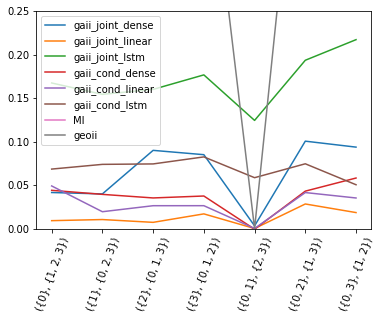

In [12]:
result_plot = pd.DataFrame.from_records(result_all, index=candidate_list)
display(result_plot)
ax = result_plot.plot(ylim=[0, 0.25])
ax.tick_params(axis='x', rotation=70)
ax

,gaii_joint_dense,gaii_joint_linear,gaii_joint_lstm,gaii_cond_dense,gaii_cond_linear,gaii_cond_lstm,MI,geoii
"({0}, {1, 2, 3})",0.041430,0.009076,0.167380,0.043954,0.048980,0.068380,1.094437,6.919015e-01
"({1}, {0, 2, 3})",0.039826,0.010356,0.154285,0.039298,0.019354,0.073796,1.094437,8.541965e-01
"({2}, {0, 1, 3})",0.089900,0.007136,0.160006,0.035195,0.026266,0.074304,1.094437,5.606993e-01
"({3}, {0, 1, 2})",0.084931,0.016867,0.176681,0.037417,0.026289,0.082384,1.094437,4.888803e-01
"({0, 1}, {2, 3})",0.003115,0.000041,0.124337,-0.000759,0.000104,0.058481,1.094437,5.960464e-08
"({0, 2}, {1, 3})",0.100477,0.028255,0.193497,0.043023,0.041392,0.074461,1.094437,5.651165e-01
"({0, 3}, {1, 2})",0.093622,0.018373,0.217177,0.058090,0.035144,0.050369,1.094437,4.468113e-01


<AxesSubplot:>

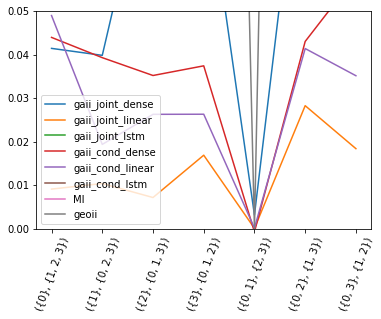

In [14]:
result_plot = pd.DataFrame.from_records(result_all, index=candidate_list)
display(result_plot)
result_plot.to_pickle("gaii_20220128.pkl")
ax = result_plot.pd.DataFrame(ylim=[0, 0.05])
ax.tick_params(axis='x', rotation=70)
ax

# AR(4)

In [ ]:
import numpy as np
from numpy.linalg import det
import var

def create_ar4():
    length = 10000
    A_ = np.array([
        [0.2, 0.2, 0, 0],
        [0.2, 0.2, 0, 0],
        [0, 0, 0.2, 0.2],
        [0, 0, 0.2, 0.2],
    ])
    L = np.eye(N,N) * 1 + np.eye(N,N,k=1) * 0.7
    SigmaE_ = L @ L.T

    state_list = np.random.multivariate_normal([0] * N, np.eye(N,N) * 0.001, size=length)
    for i in range(3, length):
        state_list[i, :] = A_ @ state_list[i-3, :]
        state_list[i, :] += -A_ @ state_list[i-2, :]
        state_list[i, :] += np.random.multivariate_normal([0] * N, SigmaE_, size=1)[0]
    reestimate = var.reestimate_var(state_list)
    SigmaX = np.cov(state_list.T)
    SigmaE = reestimate["SigmaE"]

    return {
        "A": reestimate["A"],
        "SigmaE": SigmaE,
        "SigmaX": SigmaX,
        "state_list": state_list,
        "N": N,
        "MI": 1 / 2 * np.log(det(SigmaX) / det(SigmaE))
    }

([0], [1, 2, 3])
gaii_joint_dense
Generator(
  (seq1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4, out_features=4, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 1))
  )
  (seq2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 3))
  )
  (linear_corr): Linear(in_features=4, out_features=4, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16, out_features=16, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
[Count 0/20000]    [JS: -0.027135] [G loss: 1.379987] [D loss: 1.440565]
[Count 100/20000]    [JS: -0.014980] [G loss: 1.403108] [D loss: 1.416254

/Users/sasano/gaii/src/visualize.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


{'gaii_joint_dense': 0.0726346950557949, 'gaii_joint_linear': 0.002267001154732884, 'gaii_joint_lstm': 0.013152478220772923, 'gaii_cond_dense': 0.016452012541604222, 'gaii_cond_linear': 0.0003474931743862042, 'gaii_cond_lstm': 0.005630074026894749, 'MI': 0.020786188588461676, 'geoii': 0.0429209304541259}
([1], [0, 2, 3])
gaii_joint_dense
Generator(
  (seq1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4, out_features=4, bias=True)
    (2): ReLU()
    (3): Linear(in_features=4, out_features=4, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 1))
  )
  (seq2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12, out_features=12, bias=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Unflatten(dim=-1, unflattened_size=(4, 3))
  )
  (linear_corr): Linear(in_features=4, out_features=4, bias=True)
)
Discriminator(
  (activation): ReLU()
  (linear1): Linear(in_features=16,

,gaii_joint_dense,gaii_joint_linear,gaii_joint_lstm,gaii_cond_dense,gaii_cond_linear,gaii_cond_lstm,MI,geoii
"({0}, {1, 2, 3})",0.072635,0.002267,0.013152,0.016452,0.000347,0.005630,0.020786,0.042921
"({1}, {0, 2, 3})",0.084755,0.001787,0.030547,0.019321,-0.001184,-0.000017,0.020786,0.086802
"({2}, {0, 1, 3})",0.062680,0.000605,0.027180,0.016998,-0.000037,0.005326,0.020786,0.064400
"({3}, {0, 1, 2})",0.074952,0.003927,0.051458,0.030451,-0.000365,0.005304,0.020786,0.057617
"({0, 1}, {2, 3})",0.010501,0.000226,0.054430,0.003457,-0.000232,0.001329,0.020786,0.063354
"({0, 2}, {1, 3})",0.109335,0.001909,0.062564,0.040706,-0.000288,0.009173,0.020786,0.089121
"({0, 3}, {1, 2})",0.094813,0.000537,0.036399,0.026614,0.001108,0.008703,0.020786,0.050785


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

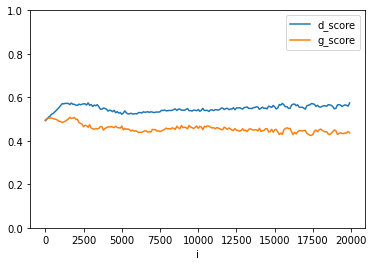

<Figure size 432x288 with 0 Axes>

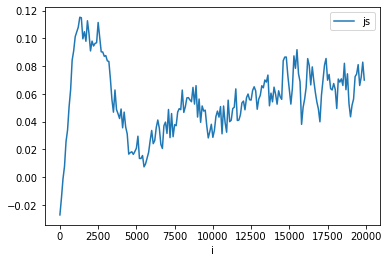

<Figure size 432x288 with 0 Axes>

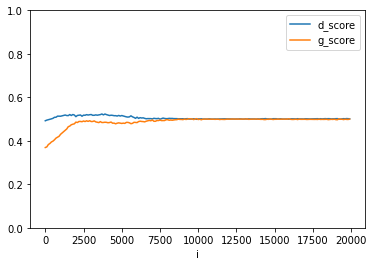

<Figure size 432x288 with 0 Axes>

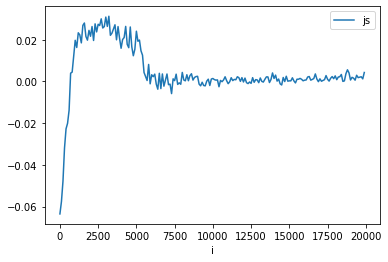

<Figure size 432x288 with 0 Axes>

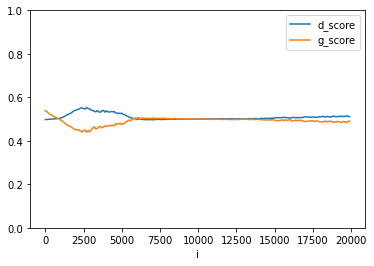

<Figure size 432x288 with 0 Axes>

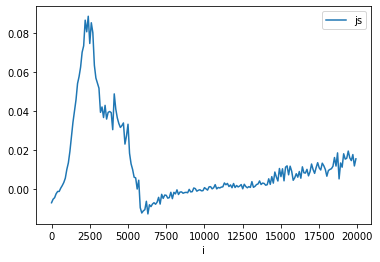

<Figure size 432x288 with 0 Axes>

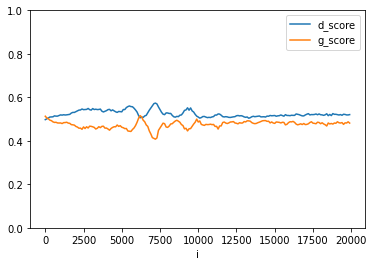

<Figure size 432x288 with 0 Axes>

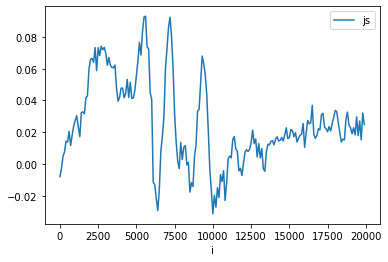

<Figure size 432x288 with 0 Axes>

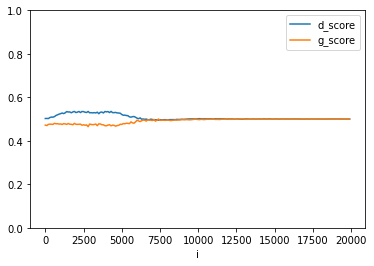

<Figure size 432x288 with 0 Axes>

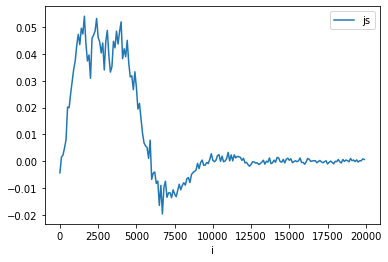

<Figure size 432x288 with 0 Axes>

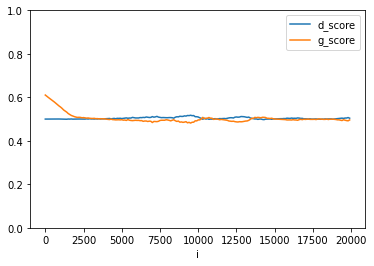

<Figure size 432x288 with 0 Axes>

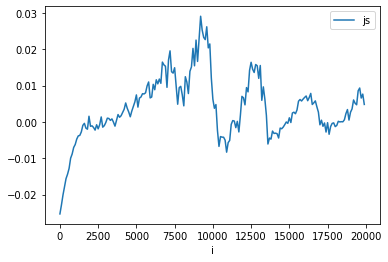

<Figure size 432x288 with 0 Axes>

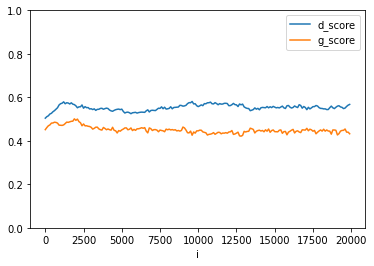

<Figure size 432x288 with 0 Axes>

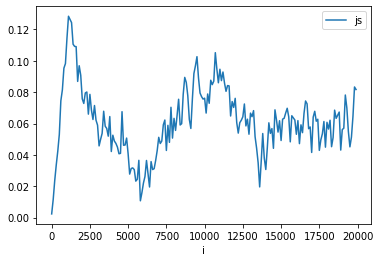

<Figure size 432x288 with 0 Axes>

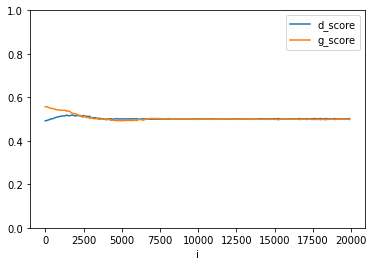

<Figure size 432x288 with 0 Axes>

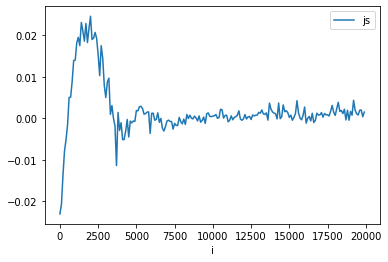

<Figure size 432x288 with 0 Axes>

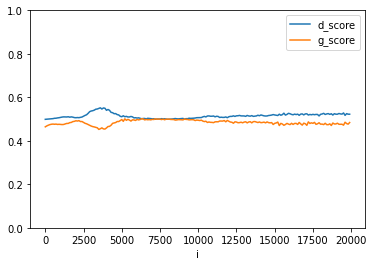

<Figure size 432x288 with 0 Axes>

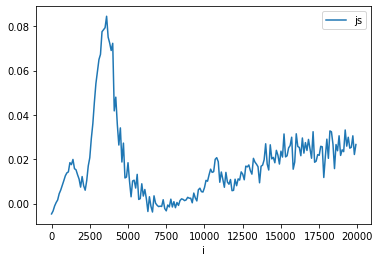

<Figure size 432x288 with 0 Axes>

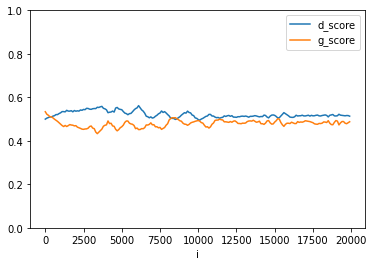

<Figure size 432x288 with 0 Axes>

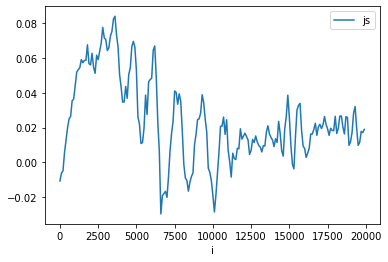

<Figure size 432x288 with 0 Axes>

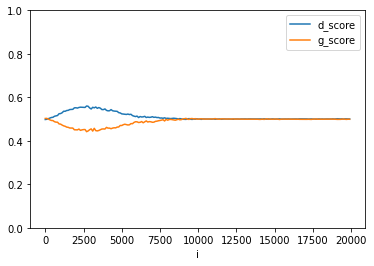

<Figure size 432x288 with 0 Axes>

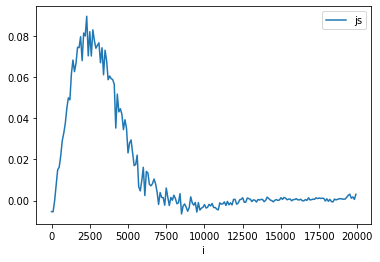

<Figure size 432x288 with 0 Axes>

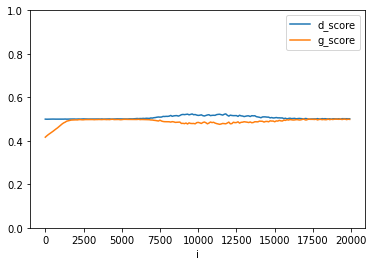

<Figure size 432x288 with 0 Axes>

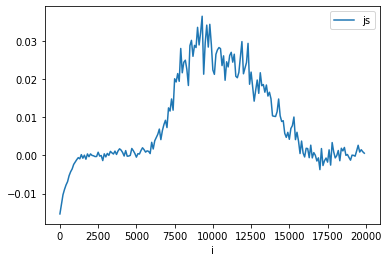

<Figure size 432x288 with 0 Axes>

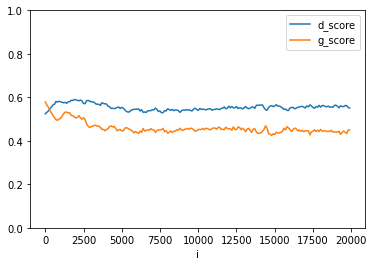

<Figure size 432x288 with 0 Axes>

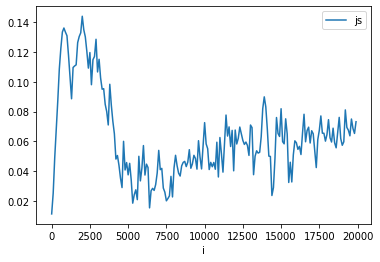

<Figure size 432x288 with 0 Axes>

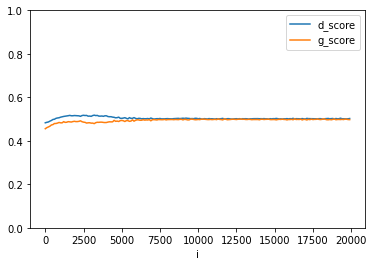

<Figure size 432x288 with 0 Axes>

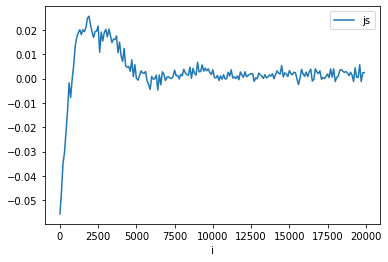

<Figure size 432x288 with 0 Axes>

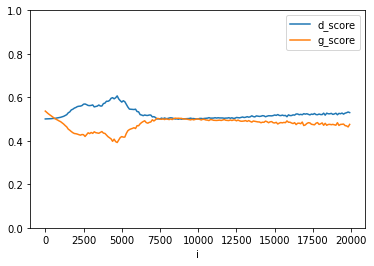

<Figure size 432x288 with 0 Axes>

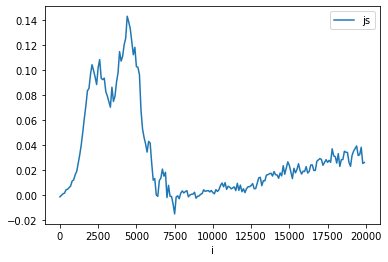

<Figure size 432x288 with 0 Axes>

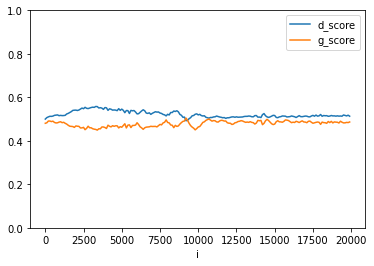

<Figure size 432x288 with 0 Axes>

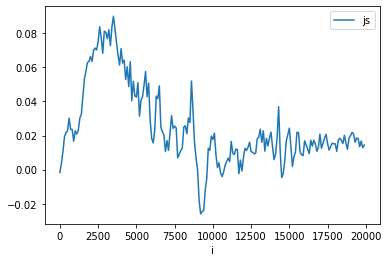

<Figure size 432x288 with 0 Axes>

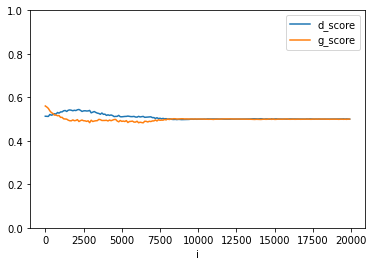

<Figure size 432x288 with 0 Axes>

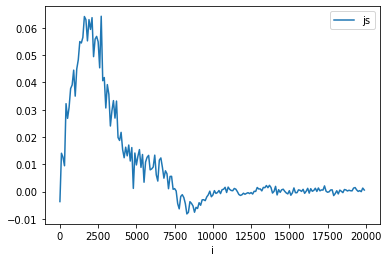

<Figure size 432x288 with 0 Axes>

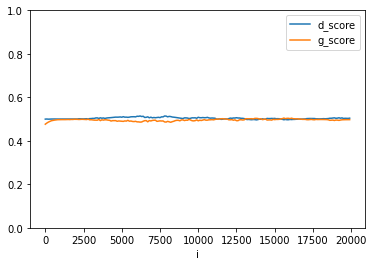

<Figure size 432x288 with 0 Axes>

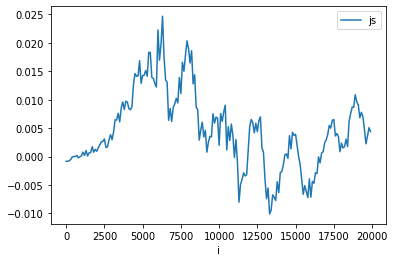

<Figure size 432x288 with 0 Axes>

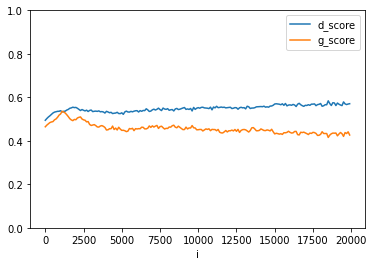

<Figure size 432x288 with 0 Axes>

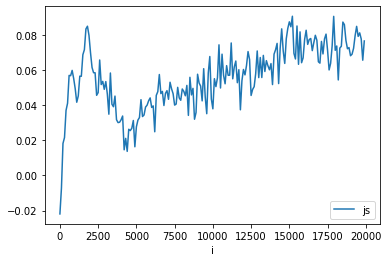

<Figure size 432x288 with 0 Axes>

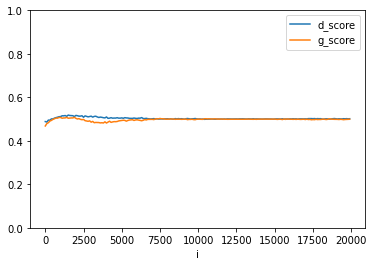

<Figure size 432x288 with 0 Axes>

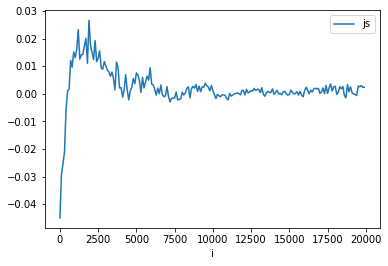

<Figure size 432x288 with 0 Axes>

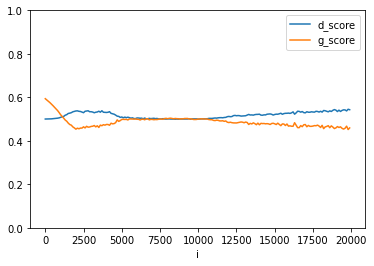

<Figure size 432x288 with 0 Axes>

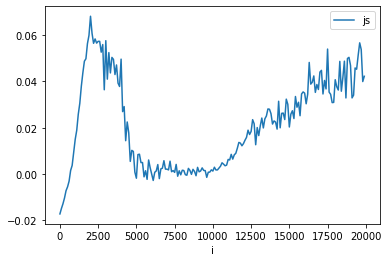

<Figure size 432x288 with 0 Axes>

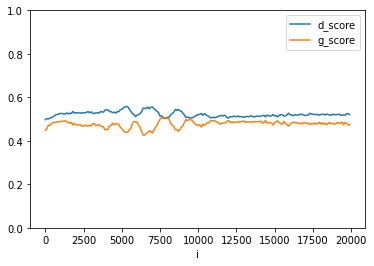

<Figure size 432x288 with 0 Axes>

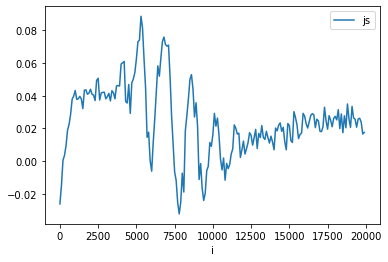

<Figure size 432x288 with 0 Axes>

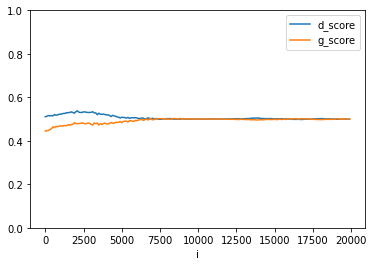

<Figure size 432x288 with 0 Axes>

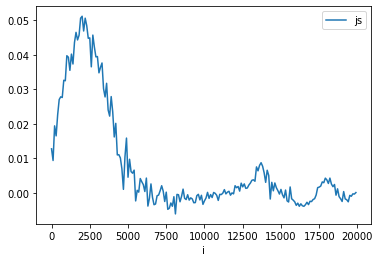

<Figure size 432x288 with 0 Axes>

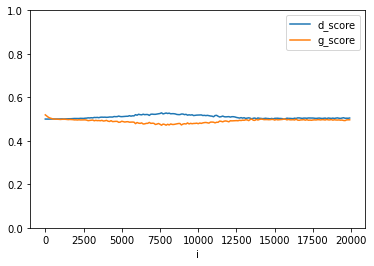

<Figure size 432x288 with 0 Axes>

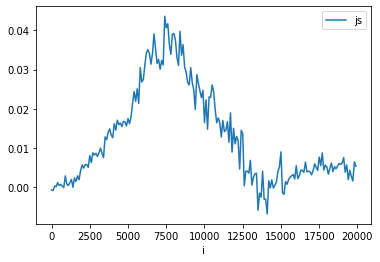

<Figure size 432x288 with 0 Axes>

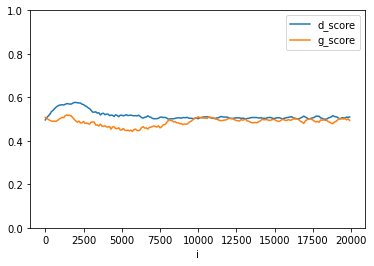

<Figure size 432x288 with 0 Axes>

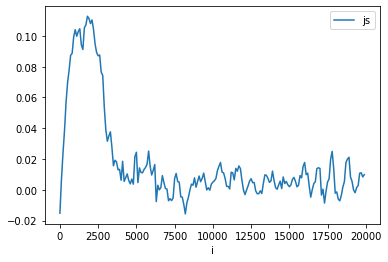

<Figure size 432x288 with 0 Axes>

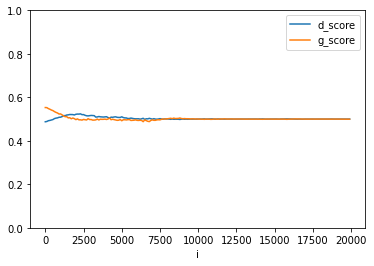

<Figure size 432x288 with 0 Axes>

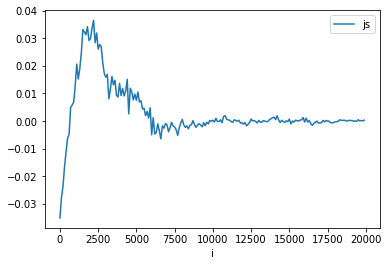

<Figure size 432x288 with 0 Axes>

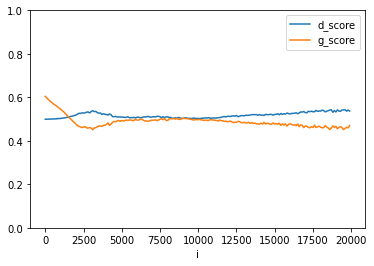

<Figure size 432x288 with 0 Axes>

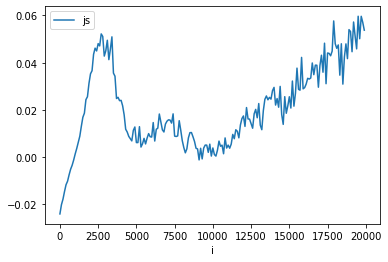

<Figure size 432x288 with 0 Axes>

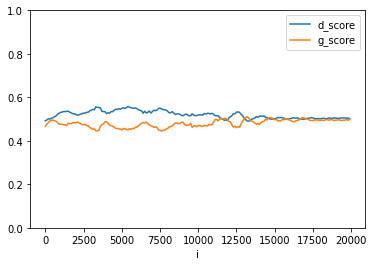

<Figure size 432x288 with 0 Axes>

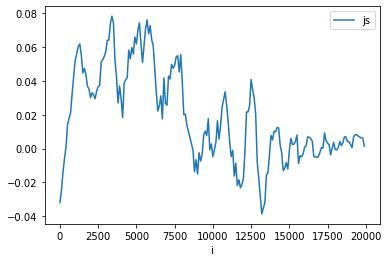

<Figure size 432x288 with 0 Axes>

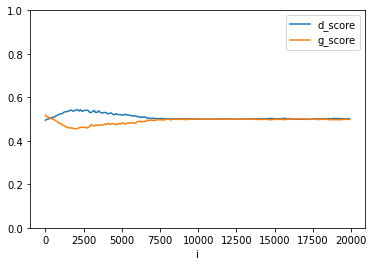

<Figure size 432x288 with 0 Axes>

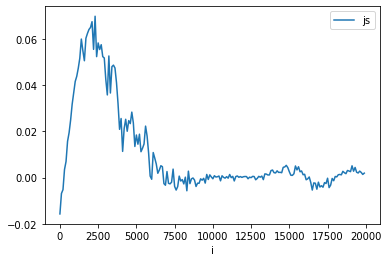

<Figure size 432x288 with 0 Axes>

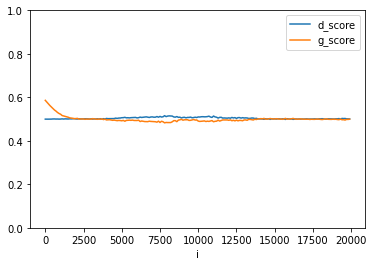

<Figure size 432x288 with 0 Axes>

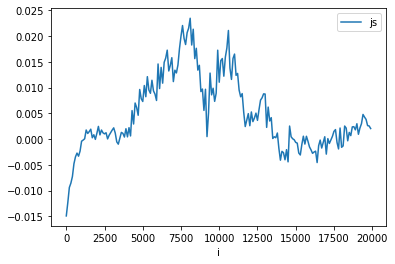

<Figure size 432x288 with 0 Axes>

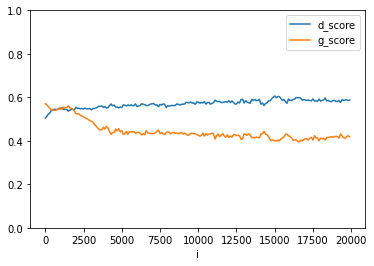

<Figure size 432x288 with 0 Axes>

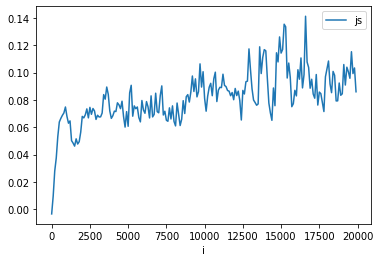

<Figure size 432x288 with 0 Axes>

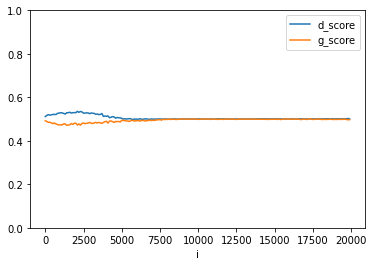

<Figure size 432x288 with 0 Axes>

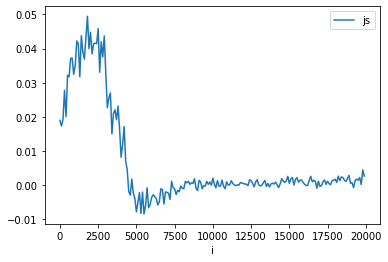

<Figure size 432x288 with 0 Axes>

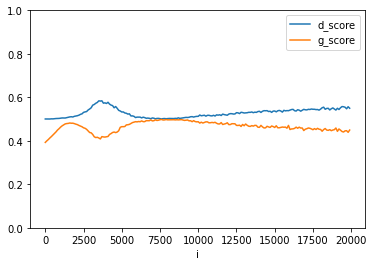

<Figure size 432x288 with 0 Axes>

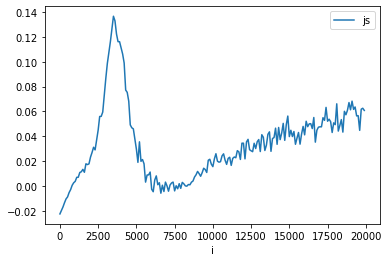

<Figure size 432x288 with 0 Axes>

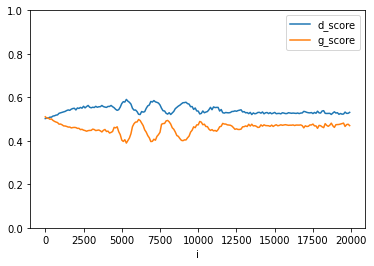

<Figure size 432x288 with 0 Axes>

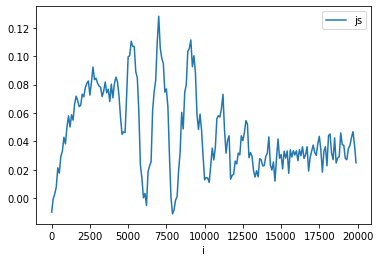

<Figure size 432x288 with 0 Axes>

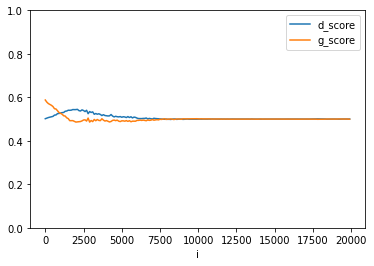

<Figure size 432x288 with 0 Axes>

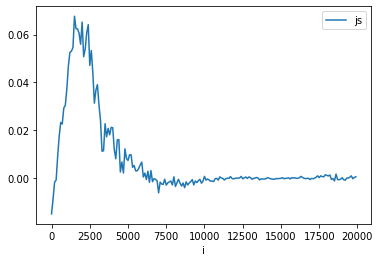

<Figure size 432x288 with 0 Axes>

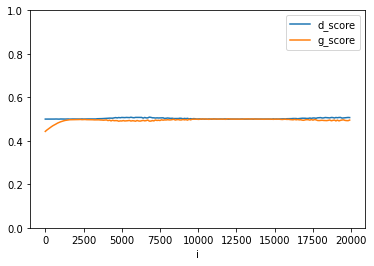

<Figure size 432x288 with 0 Axes>

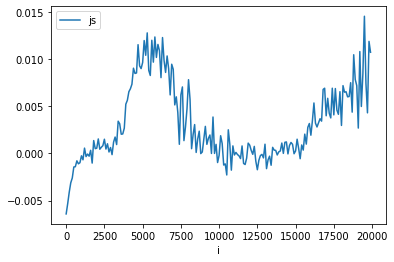

<Figure size 432x288 with 0 Axes>

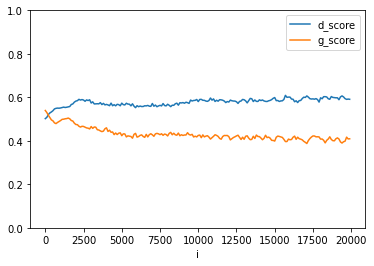

<Figure size 432x288 with 0 Axes>

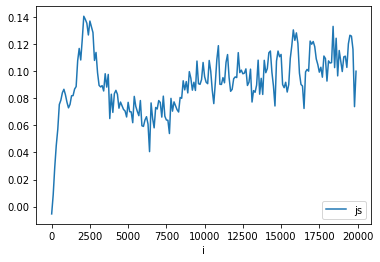

<Figure size 432x288 with 0 Axes>

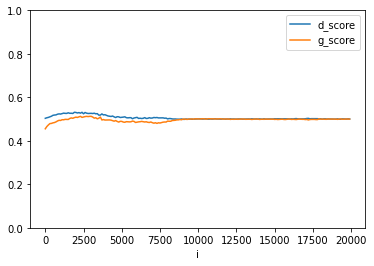

<Figure size 432x288 with 0 Axes>

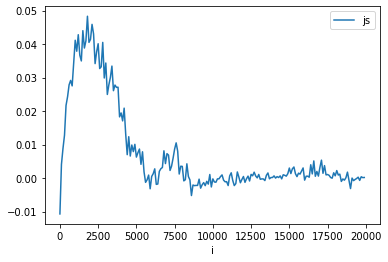

<Figure size 432x288 with 0 Axes>

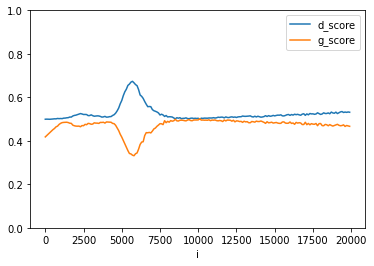

<Figure size 432x288 with 0 Axes>

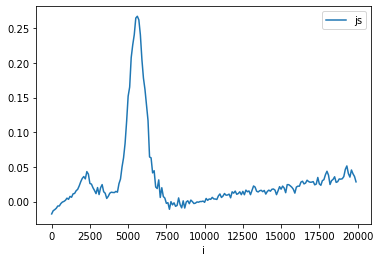

<Figure size 432x288 with 0 Axes>

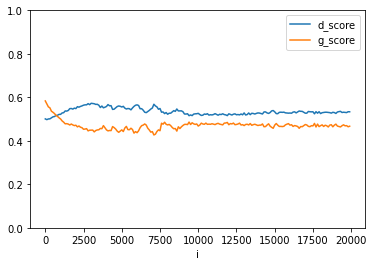

<Figure size 432x288 with 0 Axes>

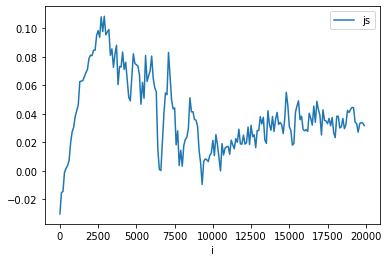

<Figure size 432x288 with 0 Axes>

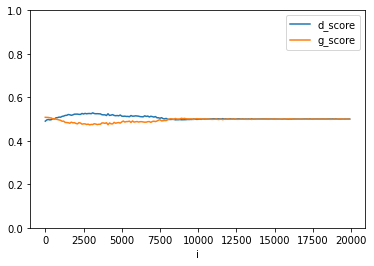

<Figure size 432x288 with 0 Axes>

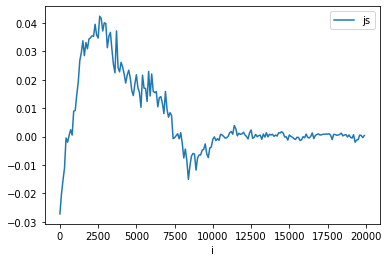

<Figure size 432x288 with 0 Axes>

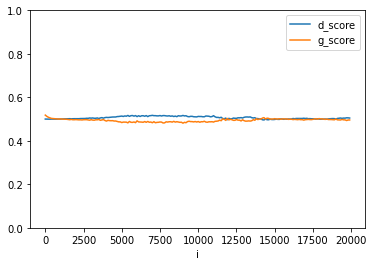

<Figure size 432x288 with 0 Axes>

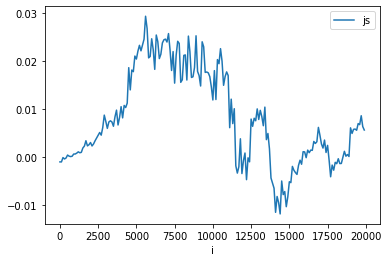

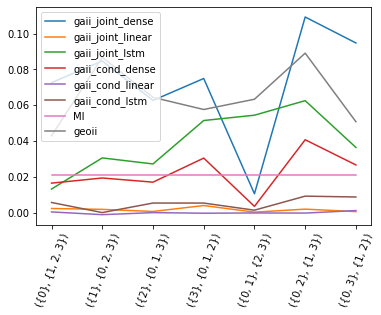

In [98]:
import gaii_joint_dense
import gaii_joint_linear
import gaii_joint_lstm
import gaii_cond_dense
import gaii_cond_linear
import gaii_cond_lstm

modules = [
    gaii_joint_dense,
    gaii_joint_linear,
    gaii_joint_lstm,
    gaii_cond_dense,
    gaii_cond_linear,
    gaii_cond_lstm
]

import importlib
for m in modules:
    importlib.reload(m)
import geoii
import pandas as pd
from IPython.display import display
import mip
import visualize
import matplotlib.pyplot as plt

data = create_ar4()
candidate_masks, candidate_list = mip.generate_masks(set(range(4)))
plt.ion()

result_all = []
for mask, ls in zip(candidate_masks, candidate_list):
    N = data["N"]
    ls = (list(ls[0]), list(ls[1]))
    print(ls)
    result = {}
    for m in modules:
        print(m.__name__)
        model_gaii = m.fit_q(data["state_list"], ls, length=4, debug=True, n_step=20000)
        gaii_result = model_gaii["js"]
        visualize.failure_check(model_gaii)
        visualize.js_all(model_gaii)
        result[m.__name__] = gaii_result

    model_geoii = geoii.fit_q(data["A"], data["SigmaE"], data["SigmaX"], mask)
    geoii_result = model_geoii["kl"]

    MI = data["MI"]
    result["MI"] = MI
    result["geoii"] = geoii_result
    print(result)
    result_all.append(result)

result_plot = pd.DataFrame.from_records(result_all, index=candidate_list)
display(result_plot)
ax = result_plot.plot()
ax.tick_params(axis='x', rotation=70)
ax

,gaii_joint_dense,gaii_joint_linear,gaii_joint_lstm,gaii_cond_dense,gaii_cond_linear,gaii_cond_lstm,MI,geoii
"({0}, {1, 2, 3})",0.072635,0.002267,0.013152,0.016452,0.000347,0.005630,0.020786,0.042921
"({1}, {0, 2, 3})",0.084755,0.001787,0.030547,0.019321,-0.001184,-0.000017,0.020786,0.086802
"({2}, {0, 1, 3})",0.062680,0.000605,0.027180,0.016998,-0.000037,0.005326,0.020786,0.064400
"({3}, {0, 1, 2})",0.074952,0.003927,0.051458,0.030451,-0.000365,0.005304,0.020786,0.057617
"({0, 1}, {2, 3})",0.010501,0.000226,0.054430,0.003457,-0.000232,0.001329,0.020786,0.063354
"({0, 2}, {1, 3})",0.109335,0.001909,0.062564,0.040706,-0.000288,0.009173,0.020786,0.089121
"({0, 3}, {1, 2})",0.094813,0.000537,0.036399,0.026614,0.001108,0.008703,0.020786,0.050785


<AxesSubplot:>

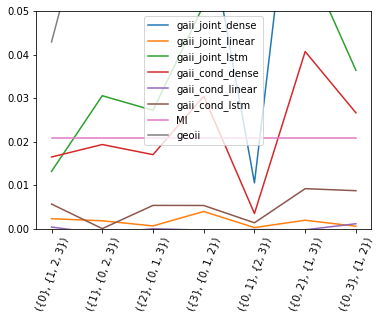

In [99]:
result_plot = pd.DataFrame.from_records(result_all, index=candidate_list)
display(result_plot)
result_plot.to_pickle("gaii_20220212.pkl")
ax = result_plot.plot(ylim=[0, 0.05])
ax.tick_params(axis='x', rotation=70)
ax